In [4]:
# crea graficos interactivos
%matplotlib inline
from astropy.io import fits #para acceder a los archivos FITS
from astropy.table import Table # para crear tablas ordenadas de los datos
import matplotlib.pyplot as plt # para plotear datos
import pandas as pd
import numpy as np
import glob
import math
import os
import random as rnd

In [5]:
from astroquery.mast import Mast
from astroquery.mast import Observations

Definimos las funciones para el manejo de ficheros locales

In [6]:
# Funcion para establecer el nombre de búsqueda en el MAST de un objeto kepler (KOI)
def get_koi_target_name(kepid):
    koi_target_name = "kplr" + format(kepid, '09')
    return koi_target_name

# Comprueba la existencia de ficheros fits para un KOI
def fits_file_exists(koi_target_name):
    fileFind = "./mastDownload/Kepler/" + koi_target_name + "*/*.fits"
    files = glob.glob(fileFind)
    fileExists = len(files) > 0
    return fileExists, files

# Comprueba la existencia de ficheros CSV para un KOI
def csv_file_exists(koi_target_name):
    fileFind = "./mastDownload/Bintables/" + koi_target_name + "*/*.csv"
    files = glob.glob(fileFind)
    fileExists = len(files) > 0
    return fileExists, files

# dado un id de kepler, obtenemos la lista de ficheros csv
def get_csv_from_koi(kepid):
    koi_target_name = get_koi_target_name(kepid)
    csvExists, csv_files = csv_file_exists(koi_target_name)
    return csv_files


En segundo lugar, las funciones que nos ayudarán a la extracción de ficheros FITS y su procesamiento a CSV

In [7]:
# dado el dataframe original descarga los ficheros fits que no estén
def download_fits_files(df_koi):
    for index in range(0, len(df_koi)):

        # Formateamos el id para que valga para hacer query
        koi_target_name = get_koi_target_name(df_koi["kepid"][index])
        fitsExists, fits_files = fits_file_exists(koi_target_name)

        prod = None
        filename = None
        if not fitsExists:
            # Buscamos las observaciones que cadencia corta para el KOI actual
            keplerObs = Observations.query_criteria(
                target_name=koi_target_name,    # nombre del KOI formateado
                obs_id="*_sc_*",                # observaciones de cadencia corta
                obs_collection='Kepler'         # colección Kepler
            )
                
            if len(keplerObs) > 0 :
                # Buscamos los productos asociados a la observación de cadencia corta
                keplerProds = Observations.get_product_list(keplerObs[-1])
                keplerProds = Observations.filter_products(
                    keplerProds,            # productos de la observación
                    extension='_slc.fits',  # archivos fit de cadencia corta
                    mrp_only=False  
                )

                
                if len(keplerProds) > 0 :
                    filename = keplerProds[-1]["dataURI"].split("/")[-1]
                    # hay que repetir esta busqueda para sacar un unico fichero porque
                    # de otra manera da error de conversion
                    prod = Observations.filter_products(
                        keplerProds, 
                        extension=filename,
                        mrp_only=False
                    )

            if not prod is None:
                Observations.download_products(
                    prod, 
                    mrp_only = False, 
                    cache = True
                )
                glob.glob(filePath)

        else:
            filename = files[-1]


        df_koi["filename"][index] = filename

# dada la ruta local del fichero FITS, lo abre y obtenemos los datos que nos serán útiles
# en ocasiones no se puede abrir el fichero por ser de gran tamaño
def get_info_from_fits_file(file):
    try:
        bjdrefi = np.nan
        bjdreff = np.nan
        times = np.nan
        sap_fluxes = np.nan
        pdcsap_fluxes = np.nan

        with fits.open(file, lazy_load_hdus=True) as hdulist: 
            header1 = hdulist[1].header
            binaryext = hdulist[1].data

            # binarytable = Table(binaryext)
            # df_bintable = binarytable.to_pandas()

            # En la cabecera tenemos los datos "BJDREF"
            # es el desplazamiento en el array de tiempo (time)
            bjdrefi = header1['BJDREFI'] 
            bjdreff = header1['BJDREFF']

            # Obtenemos las columnas que nos serán relevantes
            times = binaryext['time'] 
            sap_fluxes = binaryext['SAP_FLUX']
            pdcsap_fluxes = binaryext['PDCSAP_FLUX']
    except:
        print(str(file) + " could not be opened")

    return bjdrefi, bjdreff, times, sap_fluxes, pdcsap_fluxes

# Obtiene ficheros CSV a partir de los ficheros FITS descargados
def proccess_fits_file_to_csv(df_koi, replaceCsv = False):
    df_koi["hasFits"] = 0
    df_koi["hasCsv"] = 0

    for index in df_koi.index: 
        
        koi_target_name = get_koi_target_name(df_koi["kepid"][index])
        fitsExists, fits_files = fits_file_exists(koi_target_name)
        csvExists, csv_files = csv_file_exists(koi_target_name)        

        if (fitsExists and not csvExists) or len(fits_files) != len(csv_files) or replaceCsv:
            # print(index, koi_target_name, fitsExists, csvExists,len(fits_files), len(csv_files), replaceCsv)

            for file in fits_files:
                # fits.info(file)

                # print(koi_target_name, file)
                
                bjdrefi, bjdreff, times, sap_fluxes, pdcsap_fluxes = get_info_from_fits_file(file)

                # Convert the time array to full BJD by adding the offset back in.
                bjds = times + bjdrefi + bjdreff 

                # Almacena todos los datos necesarios en un fichero csv
                data = {
                    "bjdrefi" : bjdrefi,
                    "bjdreff" : bjdreff,
                    "times" : times,
                    "bjds" : bjds,
                    "sap_fluxes" : sap_fluxes,
                    "pdcsap_fluxes" : pdcsap_fluxes
                } 
                df_bintable = pd.DataFrame(data, columns = ["bjdrefi", "bjdreff", "times", "bjds", "sap_fluxes", "pdcsap_fluxes"]) 

                csv_path = file.replace("Kepler", "Bintables").replace(".fits",".csv")
                if not os.path.exists(os.path.dirname(csv_path)):
                    os.makedirs(os.path.dirname(csv_path))
                df_bintable.to_csv(csv_path)

        fitsExists, fits_files = fits_file_exists(koi_target_name)
        csvExists, csv_files = csv_file_exists(koi_target_name)
        df_koi["hasFits"][index] = len(fits_files)
        df_koi["hasCsv"][index] = len(csv_files)

        """    
        if index == 15:
            break
        """
    return df_koi

Establecemos otras funciones que nos ayudarán a mostrar los datos procesados en gráficas

In [8]:
# Pinta el gráfico de la curva de luz
def plot_light_curve(bjds, sap_fluxes, pdcsap_fluxes,savePlot=False, fileFrom=None):
    plt.figure(figsize=(9,4))

    # Muestra el flujo de luz corregido y no corregido
    plt.plot(bjds, np.log(sap_fluxes), '-k', label='SAP Flux') 
    plt.plot(bjds, np.log(pdcsap_fluxes), '-b', label='PDCSAP Flux') 

    plt.title('Kepler Light Curve')
    plt.legend()
    plt.xlabel('Time (days)')
    plt.ylabel('Flux (electrons/second)')

    if savePlot:
        plt.savefig(fileFrom+".jpg")
    
    plt.show()


# Pinta un grafico de un elemento aleatorio de un kepid
def get_random_plot_from_csv(df_koi_csv, savePlot=False):
    rand_idx = rnd.choice(df_koi_csv.index)
    files = get_csv_from_koi(df_koi_csv["kepid"][rand_idx])
    df_csv = pd.read_csv(files[-1])

    # display(df_csv)
    display(df_koi_csv.loc[rand_idx, ["kepid", "kepoi_name", "kepler_name", "koi_disposition", "koi_pdisposition"]])
    plot_light_curve(df_csv["bjds"], df_csv["sap_fluxes"], df_csv["pdcsap_fluxes"], savePlot, files[-1])


Cargamos el fichero descargado del MAST con todos los KOI 

https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative

Este fichero contiene los identificadores de los KOI así como otra inforamción que nos será relevante como:
- Nombre del elemento para poder identificarlo más fácilmente
- 

In [87]:
newProcess = False
df_koi = pd.read_csv("./mast-info.csv", skiprows=53)

if newProcess:
    download_fits_files(df_koi)
    df_koi_processed = proccess_fits_file_to_csv(df_koi, replaceCsv=False)
else:
    df_koi_processed = pd.read_csv("./mast-info-processed.csv")

df_koi_processed = df_koi_processed.drop("Unnamed: 0", axis=1)
display(df_koi_processed[:15])

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,hasFits,hasCsv
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,0,0
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347,0,0
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436,0,0
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597,0,0
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,1,1
5,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1,1
6,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1,1
7,10872983,K00756.03,Kepler-228 b,CONFIRMED,CANDIDATE,0.992,0,0,0,0,...,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1,1
8,6721123,K00114.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,0.182,-0.098,1.958,0.322,-0.483,298.86435,42.151569,12.660,1,1
9,10910878,K00757.01,Kepler-229 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.083,-0.028,0.848,0.033,-0.072,286.99948,48.375790,15.841,1,1


In [88]:
df_koi_csv = df_koi_processed[df_koi_processed.hasCsv > 0]
display(df_koi_csv)
print(df_koi_csv["hasCsv"].sum(), "ficheros CSV disponibles")

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag,hasFits,hasCsv
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509,1,1
5,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1,1
6,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1,1
7,10872983,K00756.03,Kepler-228 b,CONFIRMED,CANDIDATE,0.992,0,0,0,0,...,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714,1,1
8,6721123,K00114.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,0.182,-0.098,1.958,0.322,-0.483,298.86435,42.151569,12.660,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9479,9239670,K08282.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.116,1,0,0,0,...,0.260,-0.140,1.298,0.278,-0.340,298.90518,45.610840,11.858,1,1
9501,9216810,K08179.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.207,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,291.26102,45.637470,10.555,1,1
9502,9268159,K08180.01,NaN,CANDIDATE,CANDIDATE,0.295,0,0,0,0,...,0.504,-0.056,3.638,0.341,-1.820,285.32791,45.753738,10.554,1,1
9515,9899216,K07971.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,0,0,1,...,0.081,-0.175,1.935,0.516,-0.301,295.16165,46.750637,10.886,1,1


2052 ficheros CSV disponibles


kepid                      9786017
kepoi_name               K05714.01
kepler_name                    NaN
koi_disposition     FALSE POSITIVE
koi_pdisposition    FALSE POSITIVE
Name: 6796, dtype: object

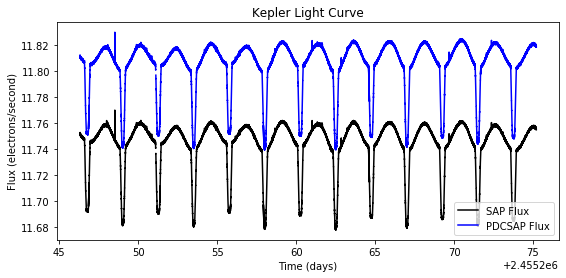

-----------------------------


kepid                      4680745
kepoi_name               K07552.01
kepler_name                    NaN
koi_disposition     FALSE POSITIVE
koi_pdisposition    FALSE POSITIVE
Name: 9106, dtype: object

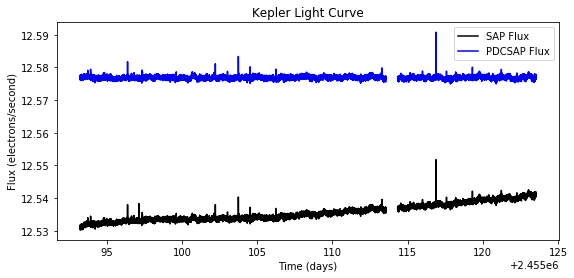

-----------------------------


kepid                      9451096
kepoi_name               K07173.01
kepler_name                    NaN
koi_disposition     FALSE POSITIVE
koi_pdisposition    FALSE POSITIVE
Name: 7882, dtype: object

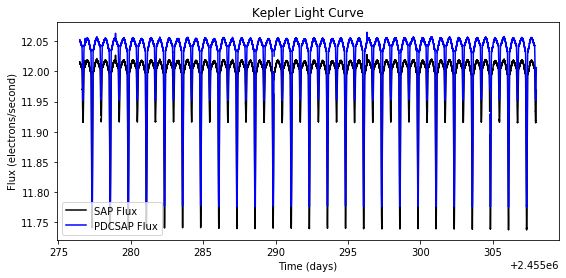

-----------------------------


In [89]:
for i in range(0, 3):
    get_random_plot_from_csv(df_koi_csv, True)
    print("-----------------------------")

In [304]:
def get_unified_info_dataframe(replaceCsv=False, col_slice=None):
    fileFind = "./mastDownload/Bintables/*/*.csv"
    files = glob.glob(fileFind)

    df_unified = pd.DataFrame()
    i = 0
    for csv_file in files:
        # obtenemos el dataframe con las mediciones flux
        csv_df = pd.read_csv(csv_file)
        csv_df = csv_df.drop("Unnamed: 0", axis=1) # quitamos la columna unnamed
        csv_df = csv_df[csv_df['pdcsap_fluxes'].notna()] # quitamos las filas con pdcsap_fluxes nan

        # trasponemos, sacamos los fluxes y quitamos el indice
        pdcsap_fluxes = csv_df.T['pdcsap_fluxes':'pdcsap_fluxes'].reset_index(drop=True)
        # renombramos todas las columnas a flux_xxxxxxxxx
        pdcsap_fluxes.rename(columns=lambda x: "flux_" + str(format(pdcsap_fluxes.columns.get_loc(x) + 0,"09")), inplace=True)

        if col_slice != None:
            pdcsap_fluxes = pdcsap_fluxes.loc[:, :"flux_" + str(format(col_slice, "09"))]


        # obtenemos el kepid del fichero
        kepid = csv_file.split("\\")[-1].split("-")[0][4:]
        
        # buscamos la/s fila/s asociada/s a ese kepid
        row = df_koi_csv.loc[df_koi_csv['kepid'] == int(kepid)]
        row = row.loc[:, 'kepid':'koi_score'] # solo las columnas que nos interesan
        filled = pd.concat([row,pdcsap_fluxes],axis=1).ffill()
        filled = filled[filled['kepid'].notna()] # quitamos las filas con pdcsap_fluxes nan

        df_unified = df_unified.append(filled, ignore_index=True)

        """
        i = i+1
        if i == 4:
            break
        """

    # ponemos las columnas al principio
    mainColumns = ["kepid","kepoi_name","kepler_name","koi_disposition","koi_pdisposition","koi_score"]
    for col_name in reversed(mainColumns):
        col = df_unified.pop(col_name)
        df_unified.insert(0, col_name, col)

    # grabamos fichero
    if replaceCsv:
        unified_file_path = "./mast-info-unified.csv"
        if col_slice != None:
            unified_file_path = "./mast-info-unified-" + str(format(col_slice, "09")) + ".csv"

        df_unified.to_csv(unified_file_path)
    return df_unified

In [306]:
newProcess = False

if newProcess:
    df_unified = get_unified_info_dataframe(replaceCsv=True, col_slice=4000)
else:
    df_unified = pd.read_csv("./mast-info-unified-000004000.csv",engine='python')

df_unified = df_unified.drop("Unnamed: 0", axis=1)
display(df_unified[:15])

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,flux_000000000,flux_000000001,flux_000000002,flux_000000003,...,flux_000003991,flux_000003992,flux_000003993,flux_000003994,flux_000003995,flux_000003996,flux_000003997,flux_000003998,flux_000003999,flux_000004000
0,757450.0,K00889.01,Kepler-75 b,CONFIRMED,CANDIDATE,0.999,11305.500,11333.433,11384.334,1.128882e+04,...,11298.839,1.127910e+04,1.128090e+04,1.134700e+04,11364.274,11293.777,11339.508,1.124740e+04,11266.217,11344.707
1,1025986.0,K07621.01,NaN,CANDIDATE,CANDIDATE,0.000,1256772.900,1256532.600,1256749.200,1.256607e+06,...,1256640.500,1.256649e+06,1.256964e+06,1.256802e+06,1256561.600,1256788.000,1256436.400,1.256765e+06,1256475.500,1256605.000
2,1026957.0,K00958.01,NaN,CANDIDATE,CANDIDATE,1.000,127373.030,127471.375,127322.200,1.274162e+05,...,127308.690,1.273479e+05,1.273386e+05,1.274128e+05,127345.910,127514.530,127492.250,1.274352e+05,127390.780,127481.140
3,1027438.0,K01010.01,NaN,FALSE POSITIVE,FALSE POSITIVE,NaN,46625.540,46659.367,46551.500,4.656250e+04,...,46627.324,4.660681e+04,4.667812e+04,4.663437e+04,46576.465,46628.560,46730.277,4.668121e+04,46699.383,46630.242
4,1161345.0,K00984.01,NaN,CANDIDATE,CANDIDATE,0.711,281025.470,281107.120,281115.750,2.811289e+05,...,279630.280,2.796694e+05,2.797465e+05,2.797129e+05,279650.660,279706.400,279592.780,2.794193e+05,279650.660,279554.780
5,1432214.0,K00998.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,7795.081,7825.623,7801.857,7.858550e+03,...,7803.190,7.809396e+03,7.810472e+03,7.838635e+03,7809.370,7797.411,7796.452,7.785333e+03,7789.092,7831.996
6,1718189.0,K00993.01,Kepler-262 c,CONFIRMED,CANDIDATE,1.000,27923.416,27926.980,27918.992,2.791225e+04,...,28030.352,2.794543e+04,2.793097e+04,2.794420e+04,27973.701,27978.523,27891.078,2.794007e+04,27989.482,27897.826
7,1718189.0,K00993.02,Kepler-262 b,CONFIRMED,CANDIDATE,1.000,27923.416,27926.980,27918.992,2.791225e+04,...,28030.352,2.794543e+04,2.793097e+04,2.794420e+04,27973.701,27978.523,27891.078,2.794007e+04,27989.482,27897.826
8,1718189.0,K00993.03,Kepler-262 b,CANDIDATE,CANDIDATE,0.149,27923.416,27926.980,27918.992,2.791225e+04,...,28030.352,2.794543e+04,2.793097e+04,2.794420e+04,27973.701,27978.523,27891.078,2.794007e+04,27989.482,27897.826
9,1865042.0,K01002.01,Kepler-746 b,CONFIRMED,CANDIDATE,0.998,51046.390,51100.766,50964.652,5.106799e+04,...,51100.340,5.106335e+04,5.109202e+04,5.103393e+04,51116.586,50963.860,51078.863,5.104519e+04,51040.840,51067.914
